In [22]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import norm
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_tv_chambolle


In [54]:
hws= pd.read_hdf('/home/gorilla/An/data/Sprints/HighRes/Windy/WindyStatsTime_std.h5')
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5') ## Low Res
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') ## High Res

### Calculating where whiff initation happened on high res data

In [55]:
index = osc.get_index(dfres.odor,4)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

### Calculating Whiff statistics

In [56]:
def avg_distance(df,index,dat): #input ; location ; storage
  
    #Distance
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline
    # dat['log_avg_dist_from_source']= np.log10(dat.avg_dist_from_source)

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 2
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
fdf = pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
fdf.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time',
       'avg_distance_along_streakline', 'avg_nearest_from_streakline'],
      dtype='object')

### Splitting train and test set for low res data

In [57]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf)

lookback_time = 10

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

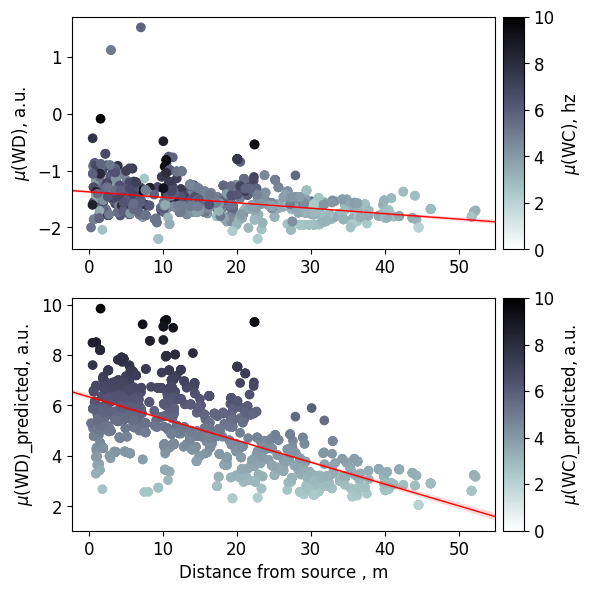

In [58]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.wd_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf.distance, traindf.mc_mean,c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

g2 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WD), a.u.')
ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


In [59]:
df_train = df[:22000]
df_test = df[15000:]

query = 'odor>2'
df_train = df_train.query(query)
df_train.reset_index(inplace=True, drop=True)
df_test = df_test.query(query)
df_test.reset_index(inplace=True, drop=True)

#### P(Whiff Initiation) from highres data

Text(0.5, 1.0, 'Probability of Whiff Initiation')

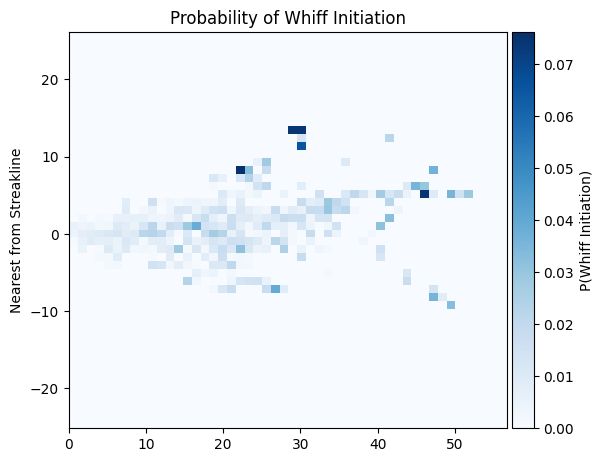

In [60]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline']*dfres.xsign, 
                                               dfres['nearest_from_streakline']*dfres.ysign, 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline']*dfres.xsign, 
                                     dfres['nearest_from_streakline']*dfres.ysign, 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)

# Apply smoothing and normalization
# smoothed_heatmap_prob = smooth_heatmap(heatmap_prob, weight=0.2)
# smoothed_prob = normalize_probabilities(smoothed_heatmap_prob)

# Plot the original and smoothed heatmaps
f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Blues')
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_title('Probability of Whiff Initiation')


#### Gaussian plume visualization

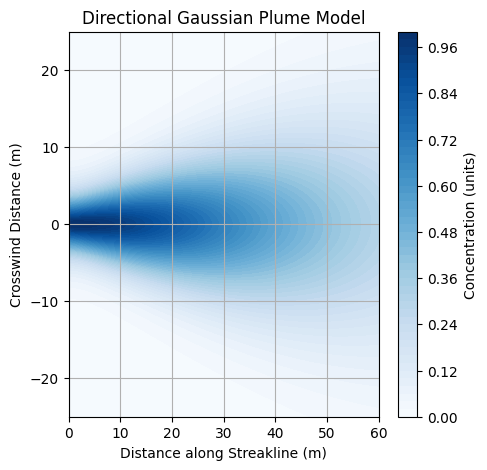

In [108]:
# def directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta):
#     """ Calculate a directional Gaussian plume model, skewed along one direction. """
#     # Transform coordinates to align plume with the wind direction
#     xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
#     yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)
    
#     return A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))

def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    sigma_x = base_sigma_x + distance_scale_factor * distance_from_source
    sigma_y = base_sigma_y + distance_scale_factor * distance_from_source
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)
    
    return A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))


# Parameters
A = 1 
x0, y0 = 0, 0  # Plume origin, modifying this can offset the plume
sigma_x, sigma_y = 30, 2  # Spread in the direction of the plume and perpendicular
theta = 0
distance_scale_factor = 0.15

# Grid for computation
x = np.linspace(0, 60, 400)
y = np.linspace(-25, 25, 200)
X, Y = np.meshgrid(x, y)

# Compute the plume concentration
Z = directional_gaussian_plume(X, Y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor)

# Visualization
plt.figure(figsize=(5, 5))
contour = plt.contourf(X, Y, Z, levels=50, cmap='Blues')
plt.colorbar(contour, label='Concentration (units)')
plt.xlabel('Distance along Streakline (m)')
plt.ylabel('Crosswind Distance (m)')
plt.title('Directional Gaussian Plume Model')
plt.grid(True)
plt.show()


#### Estimation of probability from real data probability heatmap

Optimal Parameters:
A = 0.010275761818627986
x0 = 0.0
y0 = 0.0
sigma_x = 31.166456041692538
sigma_y = 0.3327640199670137
theta = 3.1261024147074563


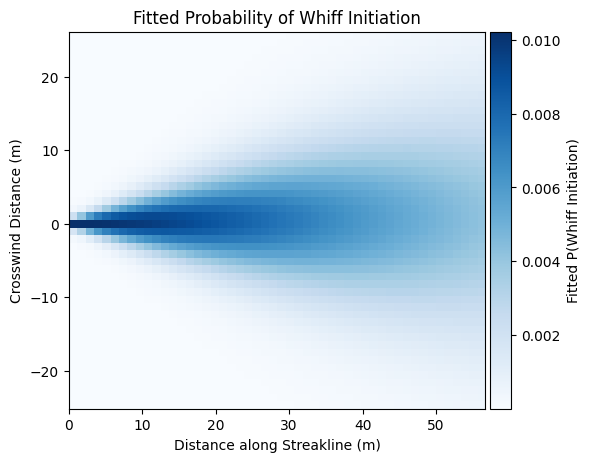

In [62]:
# Your directional_gaussian_plume function
# def directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta):
#     """ Calculate a directional Gaussian plume model, skewed along one direction. """
#     sigma_x = abs(sigma_x)
#     sigma_y = abs(sigma_y)
#     xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
#     yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)
#     return A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))

def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    sigma_x = base_sigma_x + distance_scale_factor * distance_from_source
    sigma_y = base_sigma_y + distance_scale_factor * distance_from_source
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)
    
    return A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2)))


# Prepare bin centers (same as before)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]

# # Parameters
# A = 1.0  
# x0, y0 = 0, 0  # Plume origin, modifying this can offset the plume
# sigma_x, sigma_y = 60, 10  # Spread in the direction of the plume and perpendicular
# theta = 0  

# # Grid for computation.
# x = np.linspace(0, 100, 400)
# y = np.linspace(-50, 50, 200)
# X, Y = np.meshgrid(x, y)

# # Compute the plume concentration
# Z = directional_gaussian_plume(X, Y, A, x0, y0, sigma_x, sigma_y, theta)

def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


initial_params = [1.0, 0.0, 0.0, 30, 5, 0.0, 0.04]

# Bounds as discussed
bounds = [
    (0, 1),    # A ≥ 0
    (0, 0), # x0 unbounded
    (0, 0), # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1e-5, None), # sigma_y ≥ 1e-5
    (0, np.pi),  # theta ∈ [-π, π]
    (0,1)
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape(heatmap_prob.shape)

# Plotting
f,ax=plt.subplots(1,1,figsize=(6, 6))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Crosswind Distance (m)')
ax.set_title('Fitted Probability of Whiff Initiation')

f.tight_layout()

#### Checking Residuals

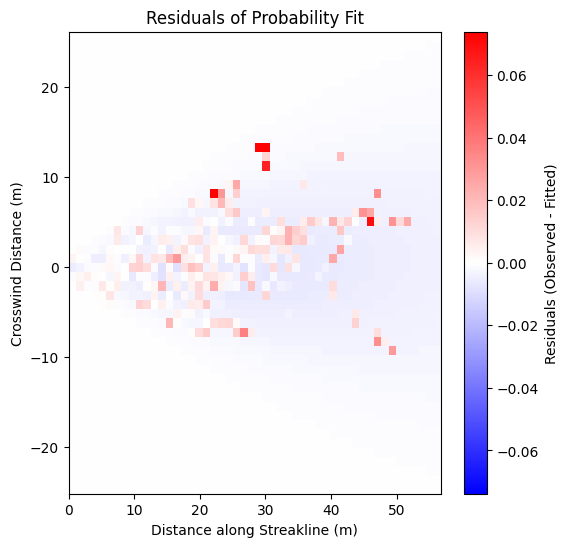

In [63]:
residuals = heatmap_prob - fitted_p_heatmap

# Plot residuals heatmap
plt.figure(figsize=(6, 6))
plt.imshow(
    residuals.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='bwr',  # Blue-White-Red colormap for residuals
    aspect='auto',
    vmin=-np.max(np.abs(residuals)),
    vmax=np.max(np.abs(residuals))
)
plt.colorbar(label='Residuals (Observed - Fitted)')
plt.xlabel('Distance along Streakline (m)')
plt.ylabel('Crosswind Distance (m)')
plt.title('Residuals of Probability Fit')
plt.show()

#### Extract Statistics from data

In [64]:
def predict_whiff_from_probability(x, y, heatmap_prob, xedges, yedges):
    # Find the corresponding bin for the given x and y coordinates
    x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
    y_bin = np.digitize(y, yedges) - 1

    # Ensure the indices are within bounds
    if x_bin < 0 or x_bin >= heatmap_prob.shape[0] or y_bin < 0 or y_bin >= heatmap_prob.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0

    # Get the probability from the heatmap for the given bin
    whiff_prob = heatmap_prob[x_bin, y_bin]

    # Use randomness based on the probability to decide if a whiff happens
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob

In [65]:
traindf.keys()

Index(['mc_min', 'mc_max', 'mc_mean', 'mc_std_dev', 'mc_k', 'wf_min', 'wf_max',
       'wf_mean', 'wf_std_dev', 'wf_k', 'wd_min', 'wd_max', 'wd_mean',
       'wd_std_dev', 'wd_k', 'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev',
       'ma_k', 'st_min', 'st_max', 'st_mean', 'st_std_dev', 'st_k', 'distance',
       'mean_whiff_time', 'nwhiffs'],
      dtype='object')

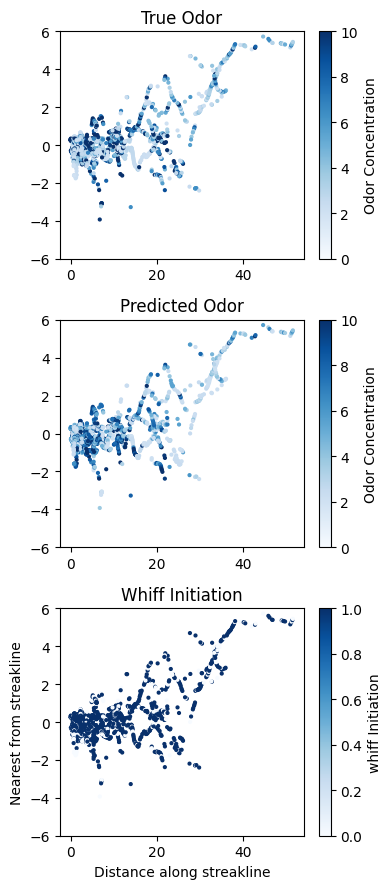

In [123]:
max_trials = 200
distance_threshold = 4

# Preparing containers for final results (one per location)
odor_concentration_samples = []
whiff_prediction_samples = []

# Data processing and initialization
test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
distances = cdist(test_locations, whiff_locations)
whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values

# whiff_durations_detected = [] 
# Testing loop for each location
for i, location in enumerate(test_locations):
    dist_along, nearest_from = location
    generated_concentration = np.nan  # Default concentration
    whiff_predicted = False
    trial = 0

    while not whiff_predicted and trial < max_trials:
        whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
                                                                     fitted_p_heatmap, xedges, yedges)
        trial += 1

        if whiff_predicted and np.min(distances[i]) <= distance_threshold:
            nearest_whiff_idx = np.argmin(distances[i])
            mean_concentration = whiff_means[nearest_whiff_idx]
            std_dev_whiff = whiff_stds[nearest_whiff_idx]
            generated_concentration = np.random.normal(mean_concentration, std_dev_whiff)
            generated_concentration = np.clip(generated_concentration, 2, 10.2)

            # duration = int(whiff_duration[nearest_whiff_idx])
            
    # Only append results once per location, outside the while loop
    odor_concentration_samples.append(generated_concentration)
    whiff_prediction_samples.append(1 if whiff_predicted else 0)
    # whiff_durations_detected.append(duration)
    

df_test['predicted_odor'] = odor_concentration_samples
df_test['predicted_odor'].interpolate(method='linear', inplace=True)
df_test['whiff_predicted'] = whiff_prediction_samples

ylim=(-6,6)

# Visualization
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 9))
cax1 = ax1.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax2.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax3 = ax3.scatter(df_test.distance_along_streakline, df_test.nearest_from_streakline, c=df_test.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


ax1.set_title('True Odor')
ax2.set_title('Predicted Odor')
ax3.set_title('Whiff Initiation')
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
ax3.set_ylim(ylim)

ax3.set_xlabel('Distance along streakline')
ax3.set_ylabel('Nearest from streakline')


plt.colorbar(cax1, label='Odor Concentration')
plt.colorbar(cax2, label='Odor Concentration')
plt.colorbar(cax3, label='whiff Initiation')

f.tight_layout()


In [124]:
new_test_df=df_test.copy()

In [135]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    # osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    # osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df.odor,th)
index_predicted = osc.get_index(new_test_df.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df,index,fdf1)
cal_stat_predicted(new_test_df,index_predicted, fdf_predicted)

fdf1.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'mean_time'],
      dtype='object')

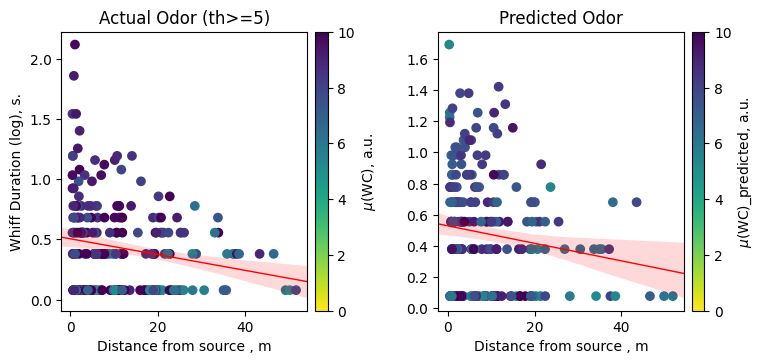

In [136]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.avg_dist_from_source,y=fdf1.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
# ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')
ax1.set_title('Actual Odor (th>='+str(th)+')')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

# mpl_functions.set_fontsize(f, 12)

In [81]:
df_test['predicted_odor'].interpolate(method='linear', inplace=True)

Text(0.5, 1.0, 'predicted odor')

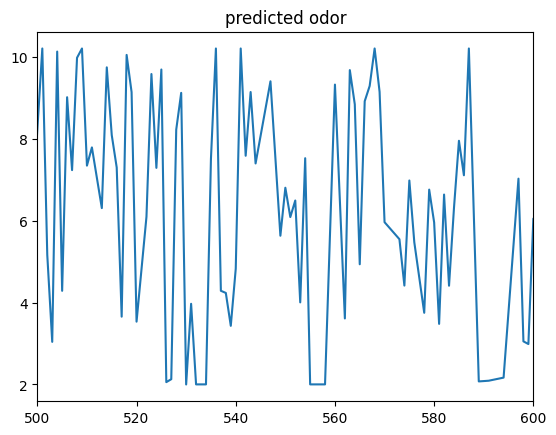

In [127]:
# plt.plot(df_test.odor)
plt.plot(df_test.predicted_odor)

plt.xlim(500,600)
plt.title('predicted odor')

Text(0.5, 1.0, 'original odor')

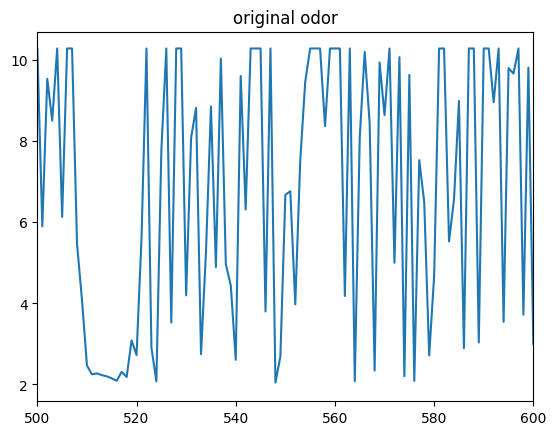

In [77]:
plt.plot(df_test.odor)
plt.xlim(500,600)
plt.title('original odor')